# SSGP

Port of GPJax's implementation: https://docs.jaxgaussianprocesses.com/_examples/uncollapsed_vi/

From this paper: https://arxiv.org/abs/1309.6835

In [17]:
import os

# XLA_FLAGS="--xla_force_host_platform_device_count=8"

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=24"
import jax

#jax.devices()

In [18]:
import sys
sys.path.insert(0, "..")

from pymc_experimental.gp import SVGP

import matplotlib.pyplot as plt
import optax
import numpy as np

import pymc as pm
import pytensor
import pytensor.tensor as pt

# Example data

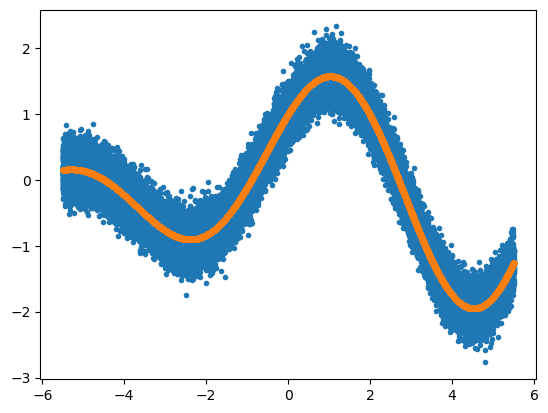

In [34]:
n_data = 50_000
noise = 0.2

low, high = -5.5, 5.5
x = np.sort(np.random.uniform(low, high, n_data))
f = lambda x: np.sin(1 * x) + np.cos(0.75 * x)
signal = f(x)
y = signal + noise * np.random.randn(n_data)

X, y = x[:, None], y[:, None]

plt.plot(x, y, '.');
plt.plot(x, signal, '.');

# Model and fit

In [35]:
with pm.Model() as model:
    pm.Data("X", np.asarray(X))
    pm.Data("y", np.asarray(y))

    eta = pm.Exponential("eta", scale=5.0)
    ell = pm.InverseGamma("ell", mu=1.0, sigma=1.0, initval=0.25)
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)

    c = pm.Exponential("c", scale=5)
    mean_func = pm.gp.mean.Constant(c)

    n_inducing = 50
    #z_init = np.linspace(-5, 5, n_inducing)[:, None]
    z_init = pm.gp.util.kmeans_inducing_points(n_inducing, np.asarray(X))
    z_init = np.sort(z_init, axis=0)
                                              
    sigma = pm.Exponential("sigma", scale=5.0)

    batch_size = 1024
    svgp = SVGP(
        input_dim=X.shape[1],
        n_data=y.shape[0],
        batch_size=batch_size,
        mean_func=mean_func,
        cov_func=cov_func,
        sigma=sigma,
        z_init=z_init,
        variational_sd_dist=pm.HalfStudentT.dist(sigma=1, nu=6),
    )
            
    initial_point = model.initial_point()
    params = tuple(initial_point.values())

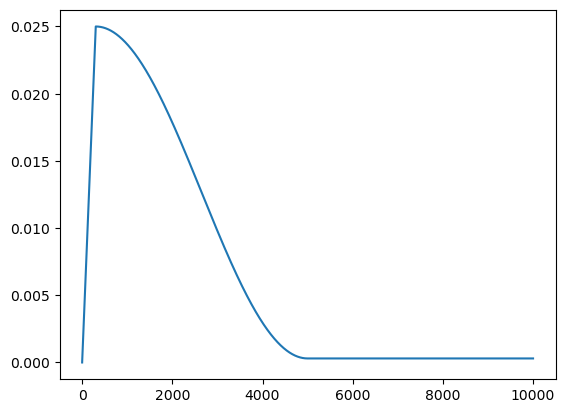

Iteration: 10000, Loss: -10885.61, finished.

In [36]:
with model:

    schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=0.025,
        warmup_steps=300,
        decay_steps=5000,
        end_value=3e-4,
    )
    
    n_steps = 10_000
    plt.plot(schedule(np.arange(n_steps)))
    plt.show()
    
    optimizer = optax.adam(learning_rate=schedule)

    #params, history = svgp.fit_scan(X, y, optimizer, num_iters=n_steps)
    params, history = svgp.fit(X, y, optimizer, params=params, n_steps=n_steps)

var_names = model.initial_point().keys()
result = dict(zip(var_names, params))

# Prediction

In [37]:
str_value_transforms = {value.name: (rv.name, model.rvs_to_transforms[rv]) for rv, value in model.rvs_to_values.items()}
var_names = model.initial_point().keys()
results_dict = {name: np.asarray(param) for name, param in zip(var_names, params)}
results = {}
for name_tr, (name, transform) in str_value_transforms.items():
    if transform is None:
        results[name] = results_dict[name_tr]
    else:
        results[name] = transform.backward(pt.as_tensor(results_dict[name_tr])).eval()

In [38]:
t = np.linspace(-6, 7, 200)[:, None]

sigma = results["sigma"] # or set sigma = None to not have likelihood noise

with model:
    f_predict = svgp.compile_pred_func(sigma=sigma, diag=True)

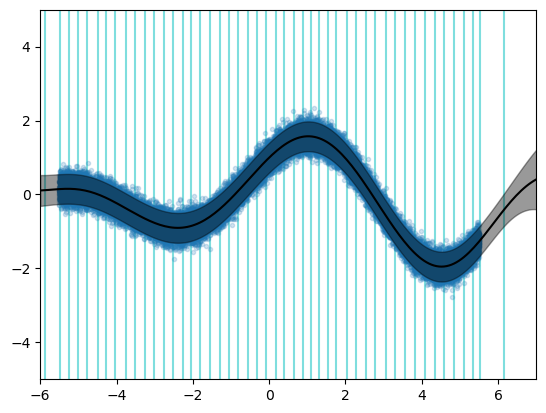

In [39]:
mu, var = f_predict(t, result)
mu = mu.squeeze()
sd = np.sqrt(var).squeeze()

plt.plot(x, y, '.', zorder=0, alpha=0.2);
plt.plot(t.flatten(), mu, color="k");
plt.fill_between(t.flatten(), mu - 2*sd, mu + 2*sd, color="k", alpha=0.4, zorder=1);
plt.xlim([-6, 7]);
plt.ylim([-5, 5]);

z = results["z"].flatten()
for z_ in z:
    plt.axvline(x=z_, color="c", zorder=-2, alpha=0.5)

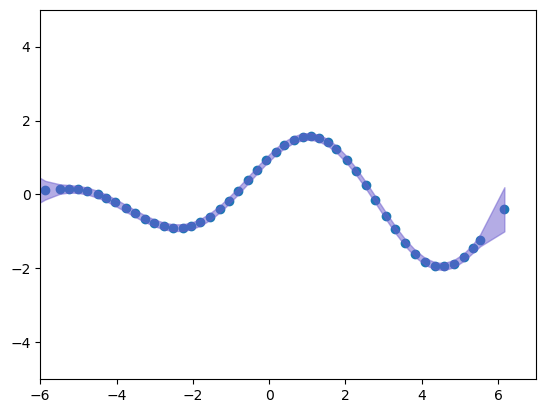

In [40]:
mu = results["variational_mean"].flatten()
plt.scatter(z, mu);

L = pm.expand_packed_triangular(n=n_inducing, packed=pt.as_tensor(results["vrc"])).eval()
Sigma = L.dot(L.T)
sd = np.sqrt(np.diag(Sigma))
plt.fill_between(z, mu - 2*sd, mu + 2*sd, color="slateblue", alpha=0.5);
plt.xlim([-6, 7]);
plt.ylim([-5, 5]);

# 2D example

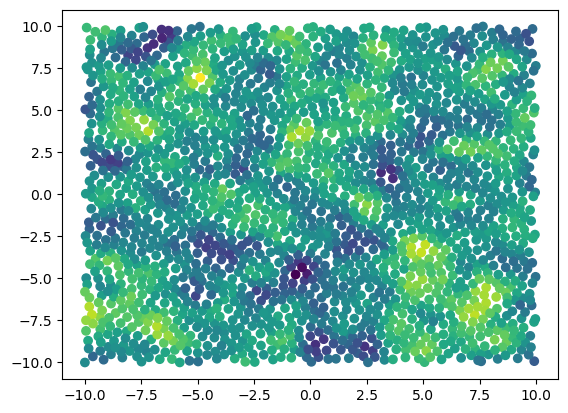

In [10]:
def simulate_2d(
    beta0_true,
    beta1_true,
    ell_true,
    eta_true,
    sigma_true,
):
    seed = sum(map(ord, "hsgp"))
    rng = np.random.default_rng(seed)
    
    # Create the 2d X locations
    from scipy.stats import qmc

    sampler = qmc.Sobol(d=2, scramble=False, optimization="lloyd")
    X = 20 * sampler.random_base2(m=11) - 10.0

    # Draw one sample from the underlying GP
    n = X.shape[0]
    cov_func = eta_true**2 * pm.gp.cov.Matern52(2, ell_true, active_dims=[0, 1])
    gp_true = pm.MvNormal.dist(mu=np.zeros(n), cov=cov_func(X))
    f_true = pm.draw(gp_true, draws=1, random_seed=rng)

    # Add the fixed effects
    mu = f_true

    # The observed data is the latent function plus a small amount
    # of Gaussian distributed noise.
    noise_dist = pm.Normal.dist(mu=0.0, sigma=sigma_true)
    y_obs = mu + pm.draw(noise_dist, draws=n, random_seed=rng)
    return y_obs[:, None], f_true, mu, X


y_data, f_true, mu, X_data = simulate_2d(1, 1, 1.0, 1.0, 0.1)
plt.scatter(X_data[:, 0], X_data[:, 1], c=y_data);


with pm.Model() as model:
    pm.Data("X", np.asarray(X_data))
    pm.Data("y", np.asarray(y_data))

    eta = pm.Exponential("eta", scale=1.0)
    ell = pm.InverseGamma("ell", mu=1.0, sigma=1.0)
    cov_func = eta**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ell)

    c = pm.Exponential("c", scale=10)
    mean_func = pm.gp.mean.Constant(c)

    n_inducing = 200
    z_init = pm.gp.util.kmeans_inducing_points(n_inducing, np.asarray(X_data))
                                              
    sigma = pm.Exponential("sigma", scale=10)

    batch_size = 2048
    svgp = SVGP(
        input_dim=X_data.shape[1],
        n_data=X_data.shape[0],
        batch_size=batch_size,
        mean_func=mean_func,
        cov_func=cov_func,
        sigma=sigma,
        z_init=z_init,
        variational_sd_dist=pm.HalfStudentT.dist(sigma=1, nu=6),
    )
            
    initial_point = model.initial_point()
    params = tuple(initial_point.values())

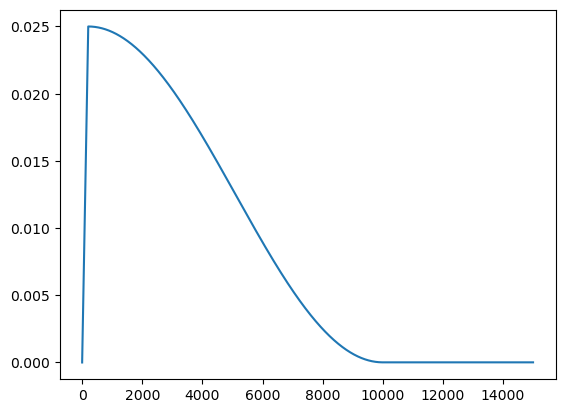

CPU times: user 53min 33s, sys: 3min 18s, total: 56min 52s
Wall time: 3min 40s


In [12]:
%%time

with model:

    schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=0.025,
        warmup_steps=200,
        decay_steps=10_000,
        end_value=1e-5,
    )
    
    n_steps = 15_000
    plt.plot(schedule(np.arange(n_steps)))
    plt.show()
    
    optimizer = optax.adam(learning_rate=schedule)

    params, history = svgp.fit(X_data, y_data, optimizer, n_steps=n_steps)

var_names = model.initial_point().keys()
result = dict(zip(var_names, params))

In [13]:
str_value_transforms = {value.name: (rv.name, model.rvs_to_transforms[rv]) for rv, value in model.rvs_to_values.items()}
var_names = model.initial_point().keys()
results_dict = {name: np.asarray(param) for name, param in zip(var_names, params)}
results = {}
for name_tr, (name, transform) in str_value_transforms.items():
    if transform is None:
        results[name] = results_dict[name_tr]
    else:
        results[name] = transform.backward(pt.as_tensor(results_dict[name_tr])).eval()

In [14]:
sigma = results["sigma"] # or set sigma = None to not have likelihood noise

with model:
    f_predict = svgp.compile_pred_func(sigma=sigma, diag=True)

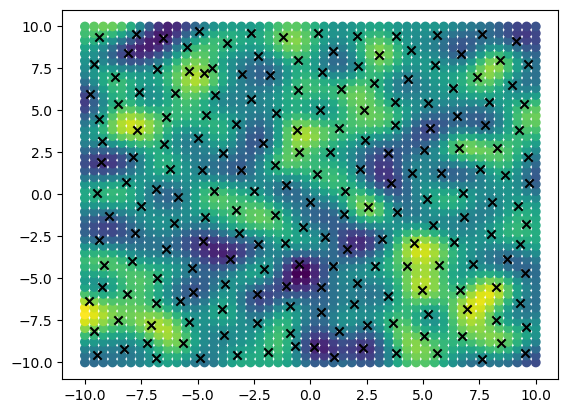

In [15]:
xx1, xx2 = np.meshgrid(np.linspace(-10, 10, 50), np.linspace(-10, 10, 50))
X_pred = np.concatenate((xx1.flatten()[:, None], xx2.flatten()[:, None]), axis=1)


mu, var = f_predict(X_pred, result)
mu = mu.squeeze()
sd = np.sqrt(var).squeeze()

z = results["z"]

plt.scatter(X_pred[:, 0], X_pred[:, 1], c=mu);
plt.scatter(z[:, 0], z[:, 1], marker="x", color="k");

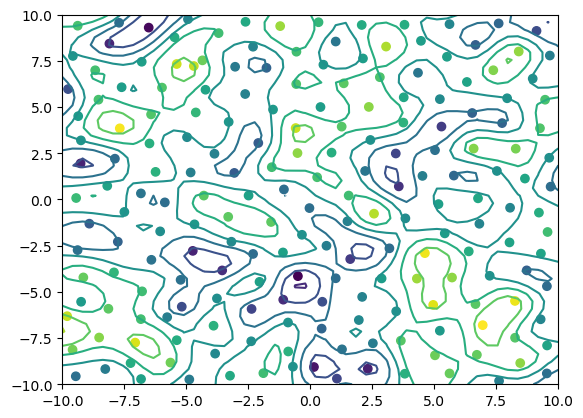

In [16]:
plt.scatter(z[:, 0], z[:, 1], c=results["variational_mean"]);
plt.contour(X_pred[:, 0].reshape(50, 50), X_pred[:, 1].reshape(50, 50), mu.reshape(50, 50));